***MACS : 207b***  
**Projet 1 : disruption Problem**

Rémi Breton, Ryan Witt

## Context

Imagine that we have events we describe by a point process $N$. At the beginning of the observation, events occur according to a Poisson process intensity $\lambda_0$ until a time $\tau$ and then switch to a new regime which is still a Poisson process but with intensity $\lambda_1$.  
  
We suppose that we know $\lambda_0$ and $\lambda_1$ but not $\tau$. We still know that $\tau$ follows an exponential distribution of parameter $\sigma$ i.e. $\tau \sim \mathrm{Exp}(\sigma)$.
  
We want to estimate $\tau$ by the observation of a single trajectory.
  
We denote by $\mathcal F _t = \sigma(N(s), s\leq t)$ the $\sigma$-field which contains the information given by the trajectory up to time $t$. We set $\hat Z(t) = \mathbb P(\tau \leq t | \mathcal F _t)$.
  
We showed that $\hat Z$ satisfies the following SDE : $$ \hat Z (t) = \int _0 ^t h(s)(1 - \hat Z (s)) \mathrm ds + \int _0 ^t \frac {(\lambda_1 - \lambda_0) \hat Z (s^-)(1- \hat Z(s^-))}{\hat \lambda (s)} (\mathrm dN(s) - \hat \lambda (s) \mathrm ds)$$

with $\hat \lambda (t) = \lambda_0 + (\lambda_1 - \lambda_0) \hat Z (t^-)$ and $h(t) = \frac {f(t)}{1 - F(t)}$ where $f$ is the distribution function of the random variable $\tau$ and $F$ the cumulative distribution function of $\tau$.


## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import expon, entropy

## Question 1

*From the last equation, describe the dynamics of $\hat Z$ between its jumps and give the size of its jumps.*

Between two jumps, say $T_{n-1}$ and $T_{n}$, $\hat Z (t)$ satisfies
$$\hat{Z}(t) = \hat{Z}(T_n) + \int_{T_n}^{t} \left( h(s) - (b - a) \hat Z(s) \right) (1 - \hat Z(s)) \, \mathrm ds$$
  
This means that $\hat Z$ satisfies the differential equation $$\frac{\mathrm d \hat Z}{\mathrm dt} = (h(t) - (\lambda_1-\lambda_0)\hat Z(t)) (1 - \hat Z(t))$$  for $ t \in [T_{n - 1}, T_{n} [$ with the initial condition $\hat Z(T_{n-1}) = \hat Z(T_{n-1} ^-) + \Delta \hat Z(T_{n-1})$ where $n \geq 1$.
  
At the $n$-th jump $T_n$, the size of the jump is  $$\Delta \hat Z(T_{n}) = \frac{(\lambda_1-\lambda_0) \hat Z(T_{n-1}^-)(1 - \hat Z(T_{n-1}^-))}{\lambda_0 + (\lambda_1-\lambda_0) \hat Z(T_{n-1}^-)}$$.

## Question 2

*Simulate a sample path of $N$ and then the corresponding trajectory of $\hat Z$.*

To tackle this question, we choose to first implement a function <span style="font-family:monospace">poisson_process</span> that generates an homogeneous Poisson process between two dates <span style="font-family:monospace">t_start</span> and <span style="font-family:monospace">t_end</span>.  
  
Then, to generate $N$, we draw a random $\tau$ that follows an exponential law of parameter $\sigma$ and we generate a first homogeneous Poisson process of intensity $\lambda_0$ on the interval $[0, \tau]$ and a second one on the intevrval $[\tau, T]$ where $T$ corresponds to the end of the simulation of $N$.
  
Finally, to simulate $\hat Z$,  we solve the differential equation on each subinterval $[T_{n-1}, T_{n})$ using the <span style="font-family:monospace">odeint</span> function and then add the jump $\Delta \hat Z (T_n)$.

### *Simulation of a Poisson process of constant intensity $\lambda$.*

In [ ]:
def generate_pp(lmb=1,t_max=10.,t_start=0.):
  """
  Generate a Poisson process.

  Parameters:
  lmb (float): The rate (lambda) of the Poisson process. Default is 1.
  t_max (float): The maximum time until which the process is generated. Default is 10.
  t_start (float): The starting time of the process. Default is 0.

  Returns:
  list: A list of event times generated by the Poisson process.
  """

  t=t_start
  t_array=[]
  while t<t_max:
    t_array.append(t)
    tmp = np.random.exponential(scale=1/lmb)
    t+=tmp
  return t_array

### *Simulation of the process $t \mapsto N(t)$.*

In [ ]:
def generate_N(lmb0=5, lmb1=10, sigma=5, t_max=20):
  """
  Generate a piecewise Poisson process with a change point.

  Parameters:
  lmb1 (float): The rate (lambda) of the Poisson process before the change point. Default is 5.
  lmb2 (float): The rate (lambda) of the Poisson process after the change point. Default is 10.
  sigma (float): The scale parameter for the exponential distribution to determine the change point. Default is 5.
  t_max (float): The maximum time until which the process is generated. Default is 20.

  Returns:
  tuple: A tuple containing:
      - list: A list of event times generated by the piecewise Poisson process.
      - float: The change point time (tau).
  """

  tau=np.random.exponential(scale=sigma)
  if tau>t_max:
    return generate_pp(lmb0,t_max),t_max
  T1 = generate_pp(lmb0,tau)
  T2 = generate_pp(lmb1,t_max,tau)[1:]
  T = T1 + T2
  return T,tau

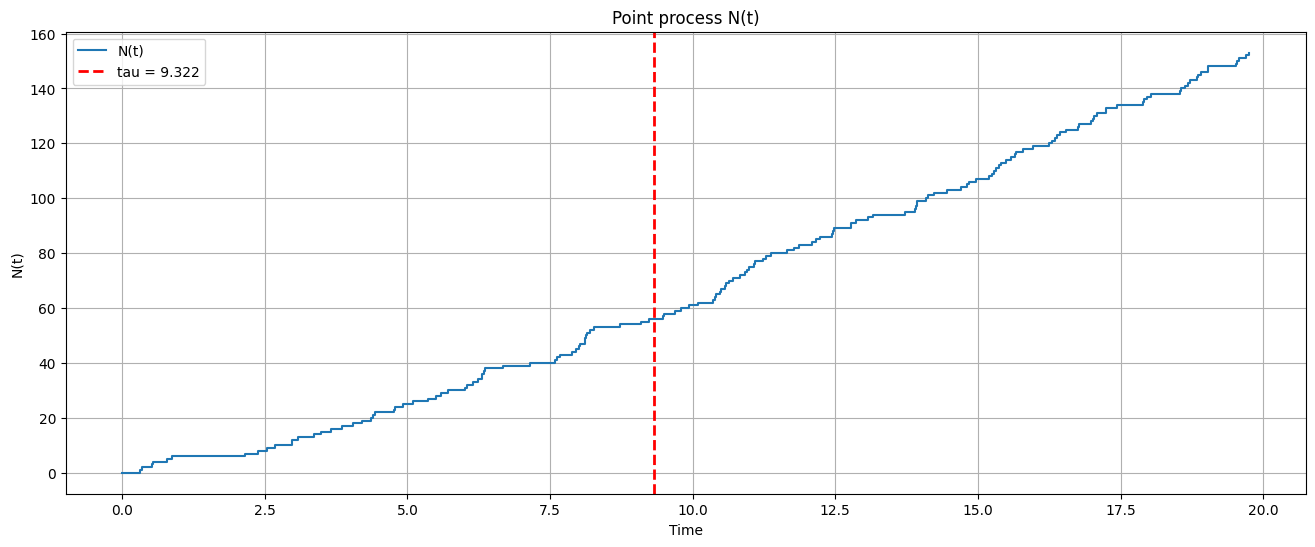

In [ ]:
def plot_point_N(T,tau):
  """
  Plot the piecewise Poisson process with a change point.

  Parameters:
  T (list): A list of event times generated by the piecewise Poisson process.
  tau (float): The change point time (tau) where the rate of the Poisson process changes.

  Returns:
  None
  """

  N=[0]+list(range(len(T)-1))
  plt.figure(figsize = (16,6))
  plt.step(T, N,label="N(t)")
  plt.axvline(x=tau, color='r', linestyle='--', linewidth=2,label='τ = ' + str(tau)[:5])
  plt.title("Point process N(t)")
  plt.xlabel("Time")
  plt.ylabel("N(t)")
  plt.legend()
  plt.grid()
  plt.show()

(T,tau) = generate_N()
plot_point_N(T,tau)

### *Simulation of $t \mapsto \hat Z(t)$.*

In [ ]:
def compute_Z(T,lmb0=5,lmb1=10,sigma=5,t_max=20):
  """
  Compute the Z process for a piecewise Poisson process with a change point.

  Parameters:
  T (list): A list of event times generated by the piecewise Poisson process.
  lmb1 (float): The rate (lambda) of the Poisson process before the change point. Default is 5.
  lmb2 (float): The rate (lambda) of the Poisson process after the change point. Default is 10.
  sigma (float): The scale parameter for the exponential distribution to determine the change point. Default is 5.
  t_max (float): The maximum time until which the process is generated. Default is 10.

  Returns:
  tuple: A tuple containing:
    - z (numpy.ndarray): The Z process values.
    - time (numpy.ndarray): The corresponding time points for the Z process.
  """

  dZ = lambda y,t : (1/sigma - (lmb1-lmb0)*y)*(1-y)
  Z_jump = lambda Z, lmb0, lmb1 : ((lmb1-lmb0)*Z*(1-Z))/(lmb0+(lmb1-lmb0)*Z) + Z
  dx = t_max/1000
  z=[0.]
  time=[0.]
  for i in range(len(T)-1):
    t_tmp=np.arange(time[-1],T[i+1],dx)
    z=np.concatenate((z, odeint(dZ,z[-1],t_tmp).flatten()[1:]))
    time=np.concatenate((time,t_tmp))
    z=np.append(z,Z_jump(z[-1],lmb0,lmb1))

  t_tmp=np.arange(time[-1],t_max,dx)
  z=np.concatenate((z, odeint(dZ,z[-1],t_tmp).flatten()[1:]))
  time=np.concatenate((time,t_tmp[1:]))

  return z, time


155


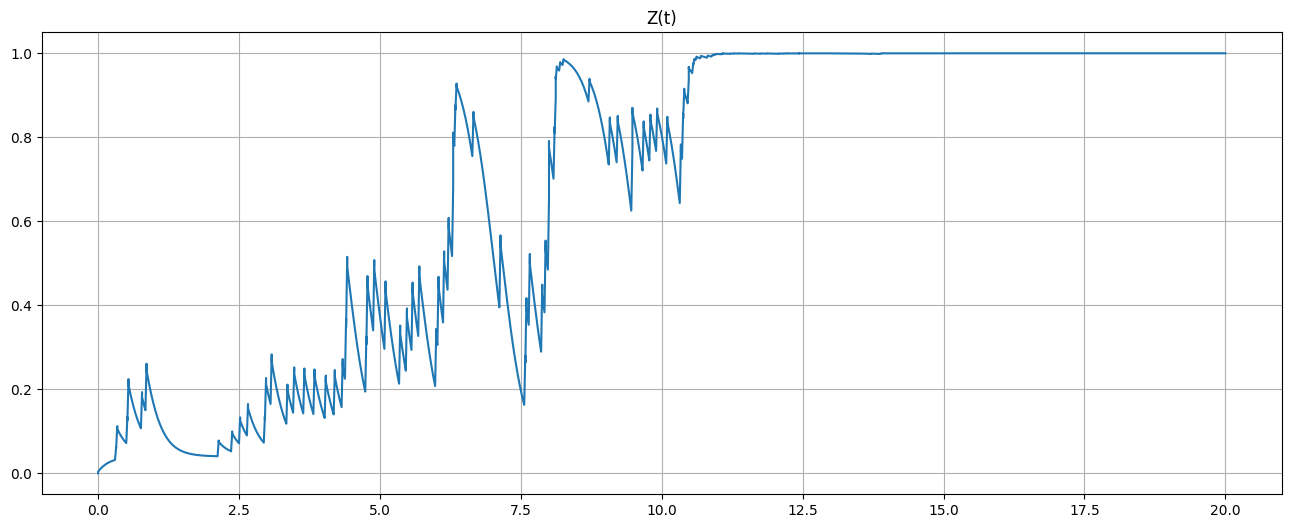

In [ ]:
z, time = compute_Z(T,5,10,5,20)
plt.figure(figsize = (16,6))
print(len(T))
plt.plot(time,z)
plt.title("Z(t)")
plt.grid()
plt.show()


## Question 3

*Suppose that $\hat Z$ is the true observation, what is a criterion to estimate $\tau$?*

### Basic idea

From the last results, a natural estimator of $\tau$ would consist in introducing a threshold on the value of $\hat Z (t)$ in order to determine if we passed $\tau$ or not i.e. we could define $$ \hat \tau = \mathrm {min} \{t : \hat Z (t) > \alpha\}$$ for a choosen $\alpha$.

However this technique could fail because of the eratic behavior of the simulated function $t \mapsto \hat Z (t)$. In fact, there is a non negligible risk that for one simulation, $t \mapsto \hat Z (t)$ reaches the threshold multiple times if $\alpha$ is to low, which will lead to a wrong prediction. On the other hand, if it is too high, it may reach $\alpha$ a considerable time after the intensity switch.

To tackle this issue, we thought about using a low pass filter on the resulting function $\hat Z$, in order to control the chaotic variations of the function and avoid the dramatic case mentioned before.

### *Implementation*

Many filters could be use, but we decided to use the most simple one i.e. the moving average window.

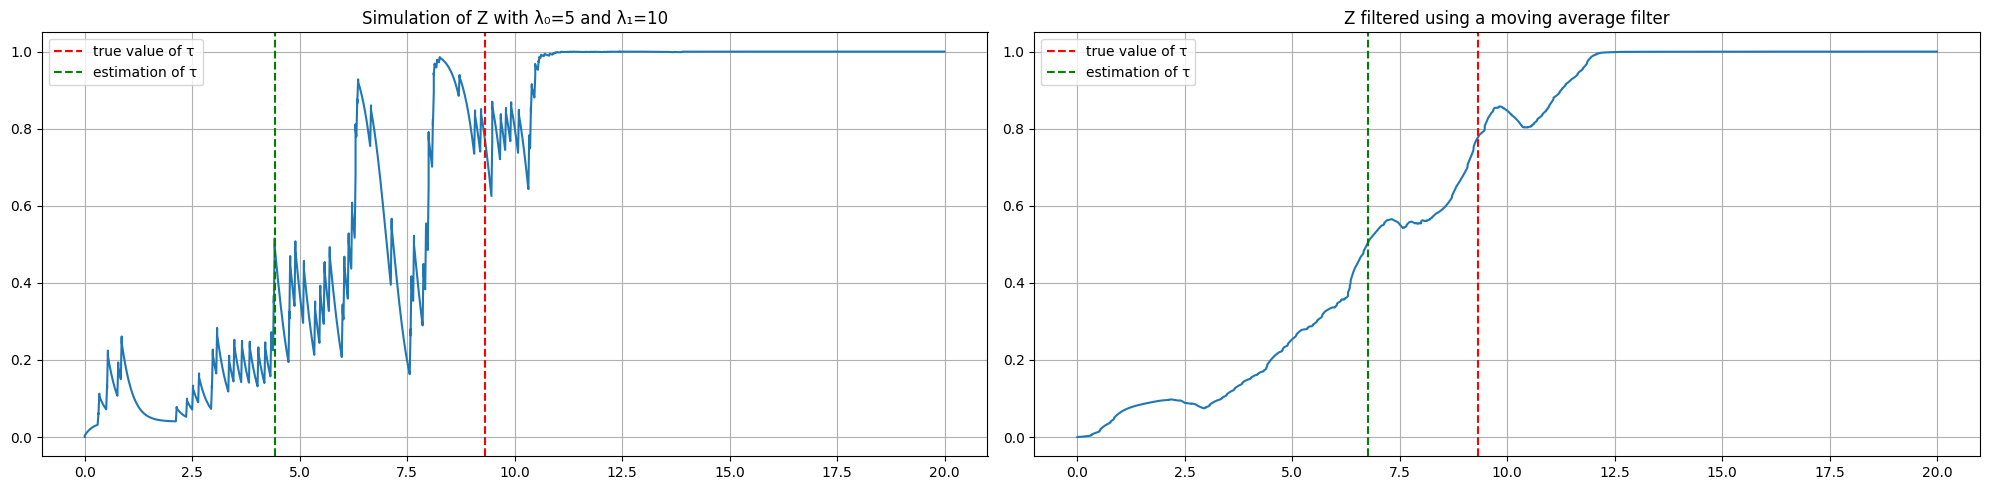

In [ ]:
threshold = 0.5

Z, time = compute_Z(T=T)

N = 100
MA_filter = 1/N * np.ones(N)

Z_MA = np.convolve(Z, MA_filter)

tau_index = np.where(Z >= threshold) [0][0]
tau_est = time[tau_index]

tau_index_MA = np.where(Z_MA >= threshold) [0][0]
tau_est_MA = time[tau_index_MA]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(time, Z)
axs[0].set_title(f"Simulation of Z with λ₀={5} and λ₁={10}")
axs[0].axvline(tau, color='r', linestyle='--', label='true value of τ')
axs[0].axvline(tau_est, color='g', linestyle='--', label='estimation of τ')
axs[0].grid()
axs[0].legend()

axs[1].plot(time, Z_MA[:len(time)])
axs[1].set_title(f"Z filtered using a moving average filter")
axs[1].axvline(tau, color='r', linestyle='--', label='true value of τ')
axs[1].axvline(tau_est_MA, color='g', linestyle='--', label='estimation of τ')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()

### Accuracy of the method

In [ ]:
def threshold_method_accuracy(n_trial, threshold, t_end, lmbda_0, lmbda_1, sigma, window_size=100) :
  error = 0
  error_MA = 0

  for _ in range (n_trial) :
    T,tau = generate_N()
    Z, time = compute_Z(T=T)

    MA_filter = 1/window_size * np.ones(window_size)

    Z_MA = np.convolve(Z, MA_filter)
    Z_MA = Z_MA[:len(time)]

    if (Z >= threshold).any() :
            tau_index = np.where(Z >= threshold) [0][0]
            tau_est = time[tau_index]

    else :
      tau_est = t_end

    if (Z_MA >= threshold).any() :
      tau_index_MA = np.where(Z_MA >= threshold) [0][0]
      tau_est_MA = time[tau_index_MA]

    else :
      tau_est_MA = t_end

    error += 1/n_trial * np.abs(tau - tau_est)
    error_MA += 1/n_trial * np.abs(tau - tau_est_MA)

  return error, error_MA

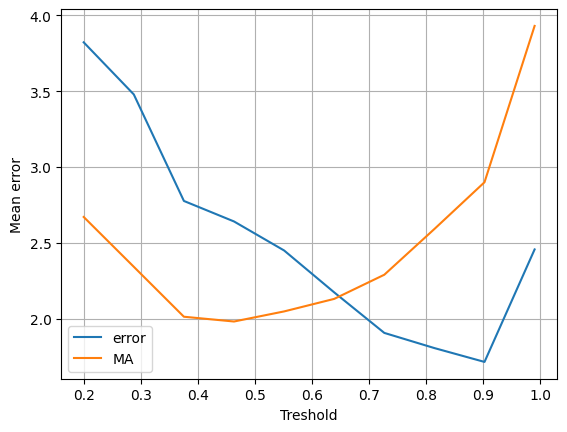

In [ ]:
n_trial = 1000

threshold = np.linspace(0.2, 0.99, 10)

errors = []
errors_MA = []

for t in threshold :
  error, error_MA = threshold_method_accuracy(n_trial=n_trial, threshold=t, t_end=20, lmbda_0=5, lmbda_1=10, sigma=5)
  errors.append(error)
  errors_MA.append(error_MA)

plt.plot(threshold, errors, label='error')
plt.plot(threshold, errors_MA, label='MA')
plt.xlabel("Treshold")
plt.ylabel("Mean error")
plt.legend()
plt.grid()
plt.show()

When we haven't smoothed the curve, we can see that the error is very sensitive to the threshold. Indeed, a threshold that is too low could distort our estimation because the curve is too erratic. However, when we smooth the curve, the error depends less on the threshold because the curve is smoother and rises only once. Nevertheless, when the curve isn't smoothed with a certain threshold, the result is better, here for $s=0.9$.

## Question 4

*Open question : which technique(s) of data analysis could be used to answer the same question with or without the Poisson hypothesis ? To get an hint of the performance, give it a try on the Poisson situation.*

### *Linear regression*

From the results of the course, we know that if $N$ is an Poisson process of intensity $\lambda$,  $t \mapsto N(t) - \lambda t$ is a $\mathcal F$-martingale which means that $\mathbb E (N(t) - \lambda t) = 0$.
  
Given, this fact, we tried to find the date $t_1$ for which we get a 'break' in the generated process $N$. To do this, we make

4.004864306547436 17


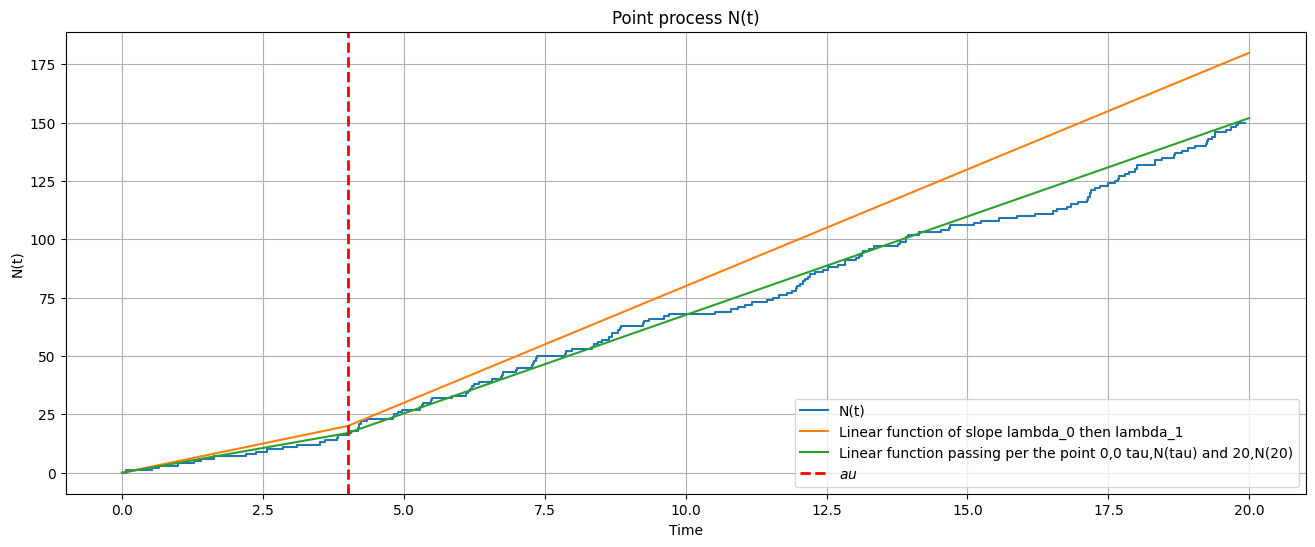

In [ ]:
#Test regression lineaire

T,tau = generate_N()
T=np.array(T)
N_tau = np.sum(T<tau)
print(tau,N_tau)
N=[0]+list(range(len(T)-1))
plt.figure(figsize = (16,6))
plt.step(T, N,label="N(t)")
plt.plot([0,tau,20],[0,tau*5,tau*5 + 10 * (20-tau)],label = "Linear function of slope λ₀ then λ₁")
plt.plot([0,tau,20],[0,N_tau,len(T)], label = "Linear function passing per the point 0,0 τ,N(τ) and 20,N(20)")
plt.axvline(x=tau, color='r', linestyle='--', linewidth=2,label='τ = ' +str(tau)[:5])
plt.title("Point process N(t)")
plt.xlabel("Time")
plt.ylabel("N(t)")
plt.legend()
plt.grid()
plt.show()


The green curve looks more like the Poisson process, even if we don't use the Poisson hypothesis, so we are going to find the function which is closer to the Poisson process curve. To compute the distance betwin two functions we will use the MSE.

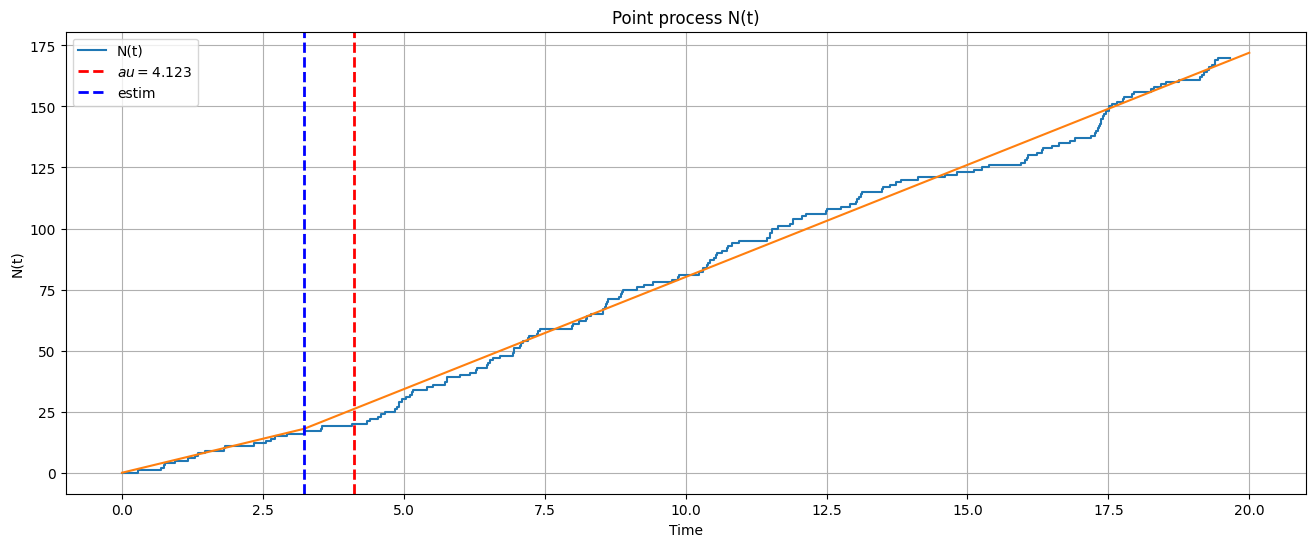

In [ ]:
T,tau = generate_N(lmb1=5,lmb2=10)

t_max = 20

T=np.array(T)

def N(t):
  return np.sum(T < t)


N_max = len(T)



def regression_error(s,N):
  k = N(s)

  def linear_1(t):
    return t*(k/s)

  def linear_2(t):
    return k + ((t-s)/(20-s))*(N_max-k)

  mse=0
  dx=20/1000
  for x in np.arange(0,s,dx):
    mse+=(1/s)*(linear_1(x)-N(x))**2
  for x in np.arange(s,20,dx):
    mse+=(1/(t_max-s))*(linear_2(x)-N(x))**2
  return mse

def estim_tau(T,t_max):
  def N(t):
    return np.sum(T < t)
  tau_array = np.linspace(0,20,100)
  score = regression_error(0,N)
  estim = 0
  for s in tau_array:
    mse = regression_error(s,N)
    if mse<score:
      score = mse
      estim = s
  return score,estim

score,estim=estim_tau(T,20)
x = np.linspace(0,20,100)

L = [N(t) for t in x]

F=[]
k=N(estim)
for a in x:
  if a<estim:
    F.append(a*(k/estim))
  else :
    F.append(k + ((a-estim)/(20-estim))*(N_max-k))


N=[0]+list(range(len(T)-1))
plt.figure(figsize = (16,6))
plt.step(T, N,label="N(t)")
plt.plot(x,F)
plt.axvline(x=tau, color='r', linestyle='--', linewidth=2,label='$τ = $' + str(tau)[:5])
plt.axvline(x=estim, color='b', linestyle='--', linewidth=2,label='estim')
plt.title("Point process N(t)")
plt.xlabel("Time")
plt.ylabel("N(t)")
plt.legend()
plt.grid()
plt.show()

It looks great, let's compute the mean error.

In [ ]:
N=10

mean_error=0
i=0
for _ in range(N):
  T,tau = generate_N(lmb1=5,lmb2=10)
  score,estim = estim_tau(np.array(T),20)
  mean_error+=np.abs(tau-estim)
mean_error/=N

print(mean_error)


7.593441222923021


### *Use of the KL divergence*

To estimate the change point $\tau$ using the Kullback-Leibler (KL) divergence, we can split the list of event times T into two segments at each potential change point and calculate the KL divergence between the empirical distributions of the inter-event times and the theoretical exponential distributions with parameters $\lambda_0$ and $\lambda_1$. The split point that minimizes the KL divergence will be our estimate of $\tau$.

In [ ]:
def kl_divergence(p, q, bins=100):
    """
    Compute the Kullback-Leibler divergence between two distributions.

    Parameters:
    p (np.ndarray): Samples from the first distribution.
    q (np.ndarray): Samples from the second distribution.
    bins (int): Number of bins to use for the histogram. Default is 100.

    Returns:
    float: The KL divergence between the distributions of p and q.
    """

    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)

    # Adding a small value to avoid division by zero
    p_hist = p_hist + 1e-10
    q_hist = q_hist + 1e-10
    return entropy(p_hist, q_hist)

def estimate_tau(T, lmbda_0, lmbda_1, t_max):
    """
    Estimate the change point tau by minimizing the KL divergence.

    Parameters:
    T (list): A list of event times.
    lmbda_0 (float): The rate (lambda) of the Poisson process before the change point.
    lmbda_1 (float): The rate (lambda) of the Poisson process after the change point.
    t_max (float): The maximum time until which the process is generated.

    Returns:
    float: The estimated change point tau.
    """

    best_kl_div = float('inf')
    best_tau = None

    for k in range(1, len(T) - 1):
        T1 = T[:k]
        T2 = T[k:]

        inter_event_times_1 = np.diff(T1)
        inter_event_times_2 = np.diff(T2)

        theoretical_exp_0 = expon(scale=1/lmbda_0).rvs(size=1000)
        theoretical_exp_1 = expon(scale=1/lmbda_1).rvs(size=1000)

        kl_div_1 = kl_divergence(inter_event_times_1, theoretical_exp_0)
        kl_div_2 = kl_divergence(inter_event_times_2, theoretical_exp_1)

        total_kl_div = kl_div_1 + kl_div_2

        if total_kl_div < best_kl_div:
            best_kl_div = total_kl_div
            best_tau = (T[k-1] + T[k]) / 2

    return best_tau

In [ ]:
# Test of the function

T, tau_true = generate_N(lmb0=5, lmb1=10, sigma=5, t_max=20)
print("True change point (tau):", tau_true)
tau_est = estimate_tau(T, lmbda_0=5, lmbda_1=10, t_max=20)
print("Estimated change point (tau):", tau_est)

True change point (tau): 12.977047949339003


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Estimated change point (tau): 14.875073714621223


In [ ]:
def simulate_and_evaluate(n_simulations, lmbda_0, lmbda_1, sigma, t_max):
    """
    Simulate multiple trajectories and evaluate the accuracy of the change point estimation method.

    Parameters:
    n_simulations (int): Number of simulations to perform.
    lmbda_0 (float): The rate (lambda) of the Poisson process before the change point.
    lmbda_1 (float): The rate (lambda) of the Poisson process after the change point.
    sigma (float): The scale parameter for the exponential distribution to determine the change point.
    t_max (float): The maximum time until which the process is generated.

    Returns:
    float: The average error of the estimated change points.
    float: The accuracy of the estimated change points.
    """
    total_error = 0

    for _ in range(n_simulations):
        T, tau_true = generate_N(lmb0=lmbda_0, lmb1=lmbda_1, sigma=sigma, t_max=t_max)
        tau_est = estimate_tau(T, lmbda_0, lmbda_1, t_max)
        error = abs(tau_est - tau_true)
        total_error += error

    average_error = total_error / n_simulations

    return average_error

In [ ]:
# Example usage

n_simulations = 200
average_error = simulate_and_evaluate(n_simulations, lmbda_0=5, lmbda_1=10, sigma=5, t_max=20)
print(f"Average Error: {average_error}")

Average Error: 6.919882628353383


## Conclusion

To conclude, the best method remains the first one proposed in question 3 by far. Indeed, it is better because it allows us to estimate if we have reached $\tau$ at a moment $t$ using only the information available at that moment, whereas the other methods (linear regression and KL divergence) use all the information up to $t_{\text{max}}$ (in this case, 20).
